In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

## Load Data

In [10]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/20220628/atlas_mm_vmm_bkgr_1_TEST/*.h5"

files=glob(DATA_LOC)

print(len(files))

201


In [11]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

/sdf/home/r/rafaeltl/home/Muon/21062022/si-mu-lator//batch_slac/out_files/atlas_mm_vmm_bkgr_1/WithMuon.atlas_mm_vmm.nevs_1000.bkgr_1.mux.-2.0.2.0_Rnd60284.h5
['is_muon', 'x', 'y', 'z', 'ptype', 'ptilt', 'poffset', 'time', 'projX_at_rightend_x', 'projX_at_rightend_y', 'projX_at_middle_x', 'projX_at_middle_y', 'projY_at_topend_x', 'projY_at_topend_y', 'projY_at_middle_x', 'projY_at_middle_y', 'seg_ix', 'rdrift']
/sdf/home/r/rafaeltl/home/Muon/21062022/si-mu-lator//batch_slac/out_files/atlas_mm_vmm_bkgr_1/NoMuon.atlas_mm_vmm.nevs_1000.bkgr_1_Rnd946943.h5
/sdf/home/r/rafaeltl/home/Muon/21062022/si-mu-lator//batch_slac/out_files/atlas_mm_vmm_bkgr_1/NoMuon.atlas_mm_vmm.nevs_1000.bkgr_1_Rnd946916.h5
/sdf/home/r/rafaeltl/home/Muon/21062022/si-mu-lator//batch_slac/out_files/atlas_mm_vmm_bkgr_1/WithMuon.atlas_mm_vmm.nevs_1000.bkgr_1.mux.-2.0.2.0_Rnd60312.h5
/sdf/home/r/rafaeltl/home/Muon/21062022/si-mu-lator//batch_slac/out_files/atlas_mm_vmm_bkgr_1/NoMuon.atlas_mm_vmm.nevs_1000.bkgr_1_Rnd946968

In [12]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv'])

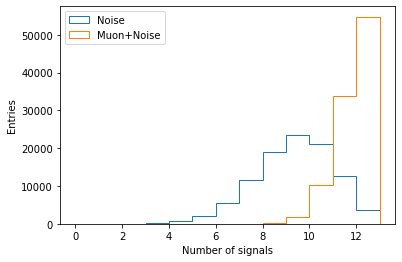

In [13]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], histtype='step', range=(0,13), bins=13, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], histtype='step', range=(0,13), bins=13, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

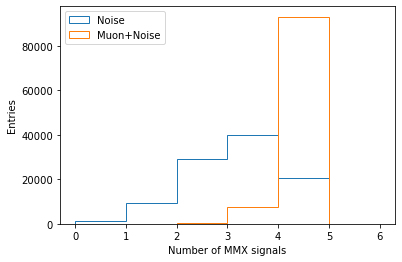

In [14]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

In [15]:
for ib in range(0,7):
    sig_eff = h_muons[0][ib:].sum()/h_muons[0].sum()
    bkg_rej = 1./(h_noise[0][ib:].sum()/h_noise[0].sum())
    print('Minimum number of MMX signals:', ib)
    print('\t', 'Signal efficiency:', sig_eff)
    print('\t', 'Background rejection:', bkg_rej)

Minimum number of MMX signals: 0
	 Signal efficiency: 1.0
	 Background rejection: 1.0
Minimum number of MMX signals: 1
	 Signal efficiency: 1.0
	 Background rejection: 1.0111939166573973
Minimum number of MMX signals: 2
	 Signal efficiency: 0.999990099009901
	 Background rejection: 1.1158970696542951
Minimum number of MMX signals: 3
	 Signal efficiency: 0.9978514851485148
	 Background rejection: 1.6516367720410927
Minimum number of MMX signals: 4
	 Signal efficiency: 0.9223267326732674
	 Background rejection: 4.862394242925216
Minimum number of MMX signals: 5
	 Signal efficiency: 0.0
	 Background rejection: inf
Minimum number of MMX signals: 6
	 Signal efficiency: 0.0
	 Background rejection: inf


<ipython-input-15-927cb1fc27ea>:3: RuntimeWarning: divide by zero encountered in double_scalars
  bkg_rej = 1./(h_noise[0][ib:].sum()/h_noise[0].sum())


In [16]:
h_noise

(array([ 1107.,  9279., 29068., 39980., 20566.,     0.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 [<matplotlib.patches.Polygon at 0x7f8b09b4e2b0>])

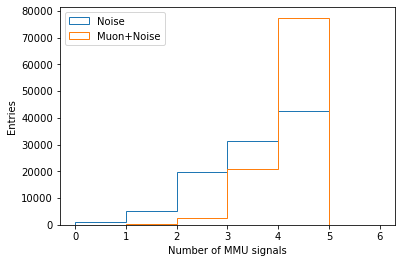

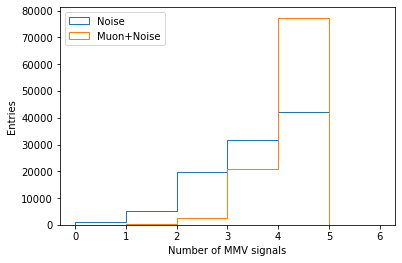

In [17]:
plt.Figure()
plt.hist(data['n_sig_mmu'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
plt.hist(data['n_sig_mmu'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMU signals')
plt.ylabel('Entries')
plt.show()

plt.Figure()
plt.hist(data['n_sig_mmv'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
plt.hist(data['n_sig_mmv'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMV signals')
plt.ylabel('Entries')
plt.show()

In [18]:
vars_of_interest = np.zeros(dmat.shape[2], dtype=bool)
training_vars = [ 'z', 'ptilt', 'time', 'projX_at_rightend_x', 'projX_at_middle_x' ]
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1
X = dmat[:,:,vars_of_interest]

## Load Model and Evaluate

In [21]:
model_loc = '../models/'
model_name = 'lstm_27062022_07.59.00'
# model_name = 'attn_deepsets_27062022_08.40.27'

In [22]:
model = keras.models.load_model(model_loc+model_name)

In [23]:
yhat = model.predict(X, batch_size=1024)

In [24]:
yhat_x3 = np.copy(yhat)
yhat_x3[data['n_sig_mmx']<4] = 0.0

yhat_x2 = np.copy(yhat)
yhat_x2[data['n_sig_mmx']<3] = 0.0

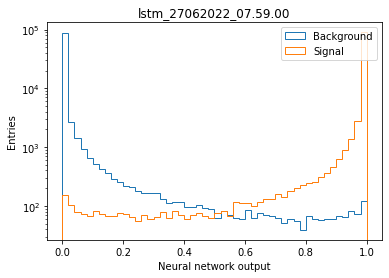

In [25]:
plt.Figure()
plt.hist(yhat[Y_mu==0], histtype='step', range=(0,1), bins=50, label='Background')
plt.hist(yhat[Y_mu==1], histtype='step', range=(0,1), bins=50, label='Signal')
plt.yscale('log')
plt.legend()
plt.xlabel('Neural network output')
plt.ylabel('Entries')
plt.title(model_name)
plt.savefig(model_loc+model_name+'/output_histogram.pdf')
plt.show()

<ipython-input-26-2ce9bc433eb8>:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label='Cut on NN')
<ipython-input-26-2ce9bc433eb8>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr_x3, 1./fpr_x3, label=r'Cut on NN & $N_{MMX} > 3$')
<ipython-input-26-2ce9bc433eb8>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr_x2, 1./fpr_x2, label=r'Cut on NN & $N_{MMX} > 2$')


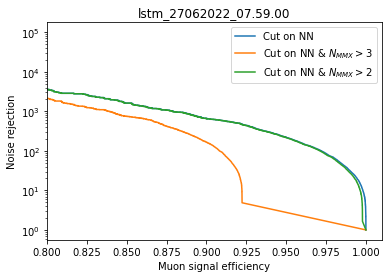

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(Y_mu, yhat)
fpr_x3, tpr_x3, thresholds = metrics.roc_curve(Y_mu, yhat_x3)
fpr_x2, tpr_x2, thresholds = metrics.roc_curve(Y_mu, yhat_x2)

plt.Figure()
plt.semilogy(tpr, 1./fpr, label='Cut on NN')
plt.semilogy(tpr_x3, 1./fpr_x3, label=r'Cut on NN & $N_{MMX} > 3$')
plt.semilogy(tpr_x2, 1./fpr_x2, label=r'Cut on NN & $N_{MMX} > 2$')
plt.xlim(0.8, 1.01)
plt.xlabel('Muon signal efficiency')
plt.ylabel('Noise rejection')
plt.legend()
plt.title(model_name)
plt.savefig(model_loc+model_name+'/roc.pdf')
plt.show()